# Processing, analysis, and visualization pipeline for event-related fiber-photometry data with 2 concurrent measures
## The goal of this pipeline is to find and quantify the largest signal change (peak) following stimulus presentation

In [ ]:
%pylab inline
%load_ext autoreload
%autoreload 2
import pynit as pn #reads BIDS database format into pipeline
import pandas as pd
import matplotlib.patches as patches
import matplotlib.ticker as ticker
import numpy as np
import scipy.fftpack
from sklearn.linear_model import LinearRegression
from pandas import DataFrame, date_range, datetime, read_csv
from matplotlib import pyplot, colors, rcParams 
from datetime import timedelta  
from scipy.signal import find_peaks, peak_prominences, peak_widths, find_peaks_cwt, butter, lfilter, freqz, sosfilt, welch, filtfilt, lfilter_zi, sosfilt_zi, sosfiltfilt
from numpy import NaN, asarray
from math import isnan
import seaborn as sns

rcParams['figure.dpi'] = 300
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Liberation Sans']

import warnings
warnings.filterwarnings("ignore")

# Plot formatting helper function

In [ ]:
def tsplot(df, add_plot=None, figsize=None, xlim=None, ylim=None, xlabel=None, ylabel=None,
               label_size=None, tick_size=None, title=None, title_size=None, err=0, **kwargs):
        """

        :param df:
        :param figsize:
        :param xlim:
        :param ylim:
        :param xlabel:
        :param ylabel:
        :param label_size:
        :param tick_size:
        :param title:
        :param title_size:
        :param err: 0 = standard deviation, 1 = standard error
        :param kwargs:
        :return:
        """
        if not add_plot:
            fig, axes = plt.subplots(1,1,figsize=figsize)
        else:
            fig, axes = add_plot
        fig.patch.set_facecolor('white')
        axes.spines['top'].set_visible(False)
        axes.spines['right'].set_visible(False)
        for axis in ['top','bottom','left','right']:
              axes.spines[axis].set_linewidth(5)
        if xlim:
            axes.set_xlim(xlim)
        if ylim:
            axes.set_ylim(ylim)
        if title:
            axes.set_title(title, size=title_size)
        if xlabel:
            axes.set_xlabel(xlabel, size=label_size)
        else:
            axes.set_xlabel('Time (s)', size=label_size)
        if ylabel:
            axes.set_ylabel(ylabel, size=label_size)
        else:
            axes.set_ylabel('Responses', size=label_size)
        tlen = int(tick_size/5)
        
        axes.tick_params(labelsize=tick_size, direction='out', top='off', right='off', width = 5, length = tlen)
        grey2 = [colors.to_rgba('grey',.1)]
        
        if err == 1:
            sns.tsplot(df.T.values, err_style='sterr_band', ax=axes,  **kwargs)

        elif err == 0:
            sns.tsplot(df.T.values, err_style=None, ax=axes, **kwargs)
        else:
            sns.tsplot(df.T.values, err_style='unit_traces', err_palette = grey2, err_kws = {'alpha':.15}, ax=axes, **kwargs)
        return fig, axes

# load BIDS format project object from parent directory
## This should point to project in a \project\subproject\group\dtype\ directory organization

In [ ]:
prj = pn.Project('/home/user/project') 
prj.reload() # reload all updates
prj(2, ext=['.xlsx']).summary

# function to get group-level data from project object

In [3]:
def get_data(prj, group, dtype):
    new_prj = prj(2, 'my-main-project-folder-name', 'my-subproject-folder-name-if-applicable', group, dtype, ext='.xlsx') #enter your own values here
    for f, finfo in new_prj:
        df = pd.read_excel(finfo.Abspath, header=None, index_col = None).dropna()
        df=df.iloc[:400] #truncates files that might have extra time points
        return df

# function to correct baseline drift by subtracting OLS line of best fit

In [4]:
def flatten_data(y, blength):
    for name in y.columns:
        
        Y = y[name].values

        Y = Y[~numpy.isnan(Y)].reshape(-1,1)
        
        X = np.array(range(len(Y))).reshape(-1,1)

        lr = LinearRegression().fit(X, Y)  # perform linear regression
#         lr = LinearRegression().fit(X[0: blength], Y[0:blength])  # perform linear regression on predefined baseline period only

        slope = lr.coef_[0][0]
        y_int = lr.intercept_[0]

        for i in range(len(Y)):
            y[name][i] = y[name][i] - (slope * i + y_int)

# function to baseline correct, z normalize, plot group data mean +/- SEM relative to stimulus timing and export to excel, find largest group peak after stimulus and print its location, plot and export peak height for each trial

## Change veriables to fit your paradigm as needed here or when calling function

In [9]:
def plot_data(prj, photo_group, first_measure = 'G', second_measure = 'HbT', blength = 99, figsize=[7.5,7.5], figsizeb=[12.5,7.5], label_size=60, err=1, title_size=60,
              tick_size=50, first_ylabel='GCaMP (Z)', second_ylabel = 'CBV (Z)', xlabel='Time (s)', n_tick_b=100, avg_start = -2, n_tick = 2, n_tick_a = 1,
              avg_end = 2, linewidth = 5, stim_on = 100, stim_dur = 10, first_ylim = [-2,8], second_ylim = [-1,1]):
                    
    data_G = get_data(prj, photo_group, first_measure)
    data_HbT = get_data(prj, photo_group, second_measure)

    flatten_data(data_G, blength)
    flatten_data(data_HbT, blength)
    
    for col in data_G.columns:
        data_G[col]= ((data_G[col] - np.mean(data_G[col].iloc[0:blength]))/np.std(data_G[col].iloc[0:blength]))
        
    for col in data_HbT.columns:
        data_HbT[col]= ((data_HbT[col] - np.mean(data_HbT[col].iloc[0:blength]))/np.std(data_HbT[col].iloc[0:blength]))

    data_G.to_excel('{}_{}.xlsx'.format(photo_group, first_measure), index = None, header = None)
    data_HbT.to_excel('{}_{}.xlsx'.format(photo_group, second_measure), index = None, header = None)
    
    print 'Data from:'+ data_G.shape[1] + 'trials'
            
    ax = tsplot(data_G, color = 'tab:green', err=err, figsize=figsize,label_size=label_size, title_size=title_size,
                         tick_size=tick_size, ylabel= first_ylabel, xlabel=xlabel, linewidth=linewidth, ylim = first_ylim)
    ax[1].set_xlim(right = data_G.shape[0])
    ax[1].yaxis.set_major_locator(ticker.MultipleLocator(n_tick))
    ax[1].xaxis.set_major_locator(ticker.MultipleLocator(n_tick_b))
    ax[1].xaxis.set_major_formatter(FuncFormatter(numfmt))
    ylim_neg = ax[1].get_ylim()
    ax[1].add_patch(patches.Rectangle((stim_on, ylim_neg[0]), stim_dur, abs(ylim_neg[0])+abs(ylim_neg[1]), fc ='gold', ec='darkgoldenrod',
                                      lw= linewidth,  alpha=.3, fill = True))   
    
         
    ax3 = tsplot(data_HbT, color = 'tab:red', err=err, figsize=figsize,label_size=label_size, title_size=title_size,
                          tick_size=tick_size, ylabel= second_ylabel, xlabel=xlabel, linewidth=linewidth, ylim = second_ylim)
    ax3[1].set_xlim(right = data_HbT.shape[0])
    ax3[1].yaxis.set_major_locator(ticker.MultipleLocator(n_tick_a))
    ax3[1].xaxis.set_major_locator(ticker.MultipleLocator(n_tick_b))
    ax3[1].xaxis.set_major_formatter(FuncFormatter(numfmt))
    ylim_neg = ax3[1].get_ylim()
    ax3[1].add_patch(patches.Rectangle((stim_on, ylim_neg[0]), stim_dur, abs(ylim_neg[0])+abs(ylim_neg[1]), fc ='gold', ec='darkgoldenrod',
                                       lw= linewidth,  alpha=.3, fill = True))
    
    Gmean = data_G.mean(axis=1)
    Gmean = pd.DataFrame(Gmean)
    Gmean = Gmean[0].tolist();
    
    Gmeanabs = data_G.mean(axis=1).abs()
    Gmeanabs = pd.DataFrame(Gmeanabs)
    Gmeanabs = Gmeanabs[0].tolist();
    
    Gloc = Gmeanabs.index(max(Gmeanabs)) #finds largest value for peak location
    print first_measure + "peak location is at " + Gloc
    
    width, width_heights, left_ips, right_ips = peak_widths(Gmean,[Gloc], rel_height = 0.90) #gets peak width and boundaries
    
    print "90% max width: " + width + "left boundary: " + left_ips + "right boundary: " + right_ips
    
    ap = data_G.plot(cmap='summer',legend=False, figsize=figsize,  linewidth=linewidth/4)
    ap.set_prop_cycle(pyplot.rcParams["axes.prop_cycle"])
    Gdf = DataFrame()
    
    Gcsvdf = DataFrame(data=None, columns=['Name','PeakX', 'PeakY'])
    
    styles = {}
    count=0
    for name in data_G.columns:
        list = data_G[name].tolist();
               
        peakx=Gloc
        peaky=sum(list[Gloc+avg_start:Gloc+avg_end]) / len(list[Gloc+avg_start:Gloc+avg_end])
                
        newcol = []
        newcol = newcol + [NaN]*(data_G.count()[0]);
        
        newcol[peakx] = peaky

        Gdf[int(name)] = newcol

        Gcsvdf = Gcsvdf.append({'Name':name, 'PeakX': peakx, 'PeakY':peaky}, ignore_index=True);
   
    Gcsvdf.to_csv('{}_{}_{}.csv'.format(photo_group, first_measure, 'Peaks'))
    
    
    a = Gdf.plot(marker= 7, color='black', legend=False, ax = ap)

    ap.add_patch(patches.Rectangle((Gloc+avg_start-0.5,-100),avg_end-avg_start+1, 200, color='b', alpha=.09))
        
    pyplot.show()
    
    Tmean = data_HbT.mean(axis=1).abs()
    Tmean = pd.DataFrame(Tmean)
    Tmean = Tmean[0].tolist();
    
    Tloc = Tmean.index(max(Tmean))

    print second_measure + "peak location is at " + Tloc
        
    ap3 = data_HbT.plot(cmap='summer',legend=False, figsize=figsize,  linewidth=linewidth/4)
    ap3.set_prop_cycle(pyplot.rcParams["axes.prop_cycle"])
    Tdf = DataFrame()
    
    Tcsvdf = DataFrame(data=None, columns=['Name','PeakX', 'PeakY'])
    
    styles = {}
    count=0
    for name in data_HbT.columns:
        list = data_HbT[name].tolist();
               
        peakx=Tloc
        peaky=sum(list[Tloc+avg_start:Tloc+avg_end]) / len(list[Tloc+avg_start:Tloc+avg_end])
        
        newcol = []
        newcol = newcol + [NaN]*(data_HbT.count()[0]);
        
        newcol[peakx] = peaky

        Tdf[int(name)] = newcol
        Tcsvdf = Tcsvdf.append({'Name':name, 'PeakX': peakx, 'PeakY':peaky}, ignore_index=True);

    Tcsvdf.to_csv('{}_{}_{}.csv'.format(photo_group, second_measure, 'Peaks'))
    
    a3 = Tdf.plot(marker= 7, color='black', legend=False, ax = ap3)

    ap3.add_patch(patches.Rectangle((Tloc+avg_start-0.5,-100),avg_end-avg_start+1, 200, color='b', alpha=.09))
    
    pyplot.show()
    
    return ax, ax3, ap, ap3

# Optional function to convert timeseries units

In [7]:
def numfmt(x, pos): 
    s = '{:.0f}'.format((x -100) / 10) # first value is stimulus timing, second is frequency in Hz
    return s

24
112
[41.89840454] [0.13953503] [102.25541308] [144.15381762]


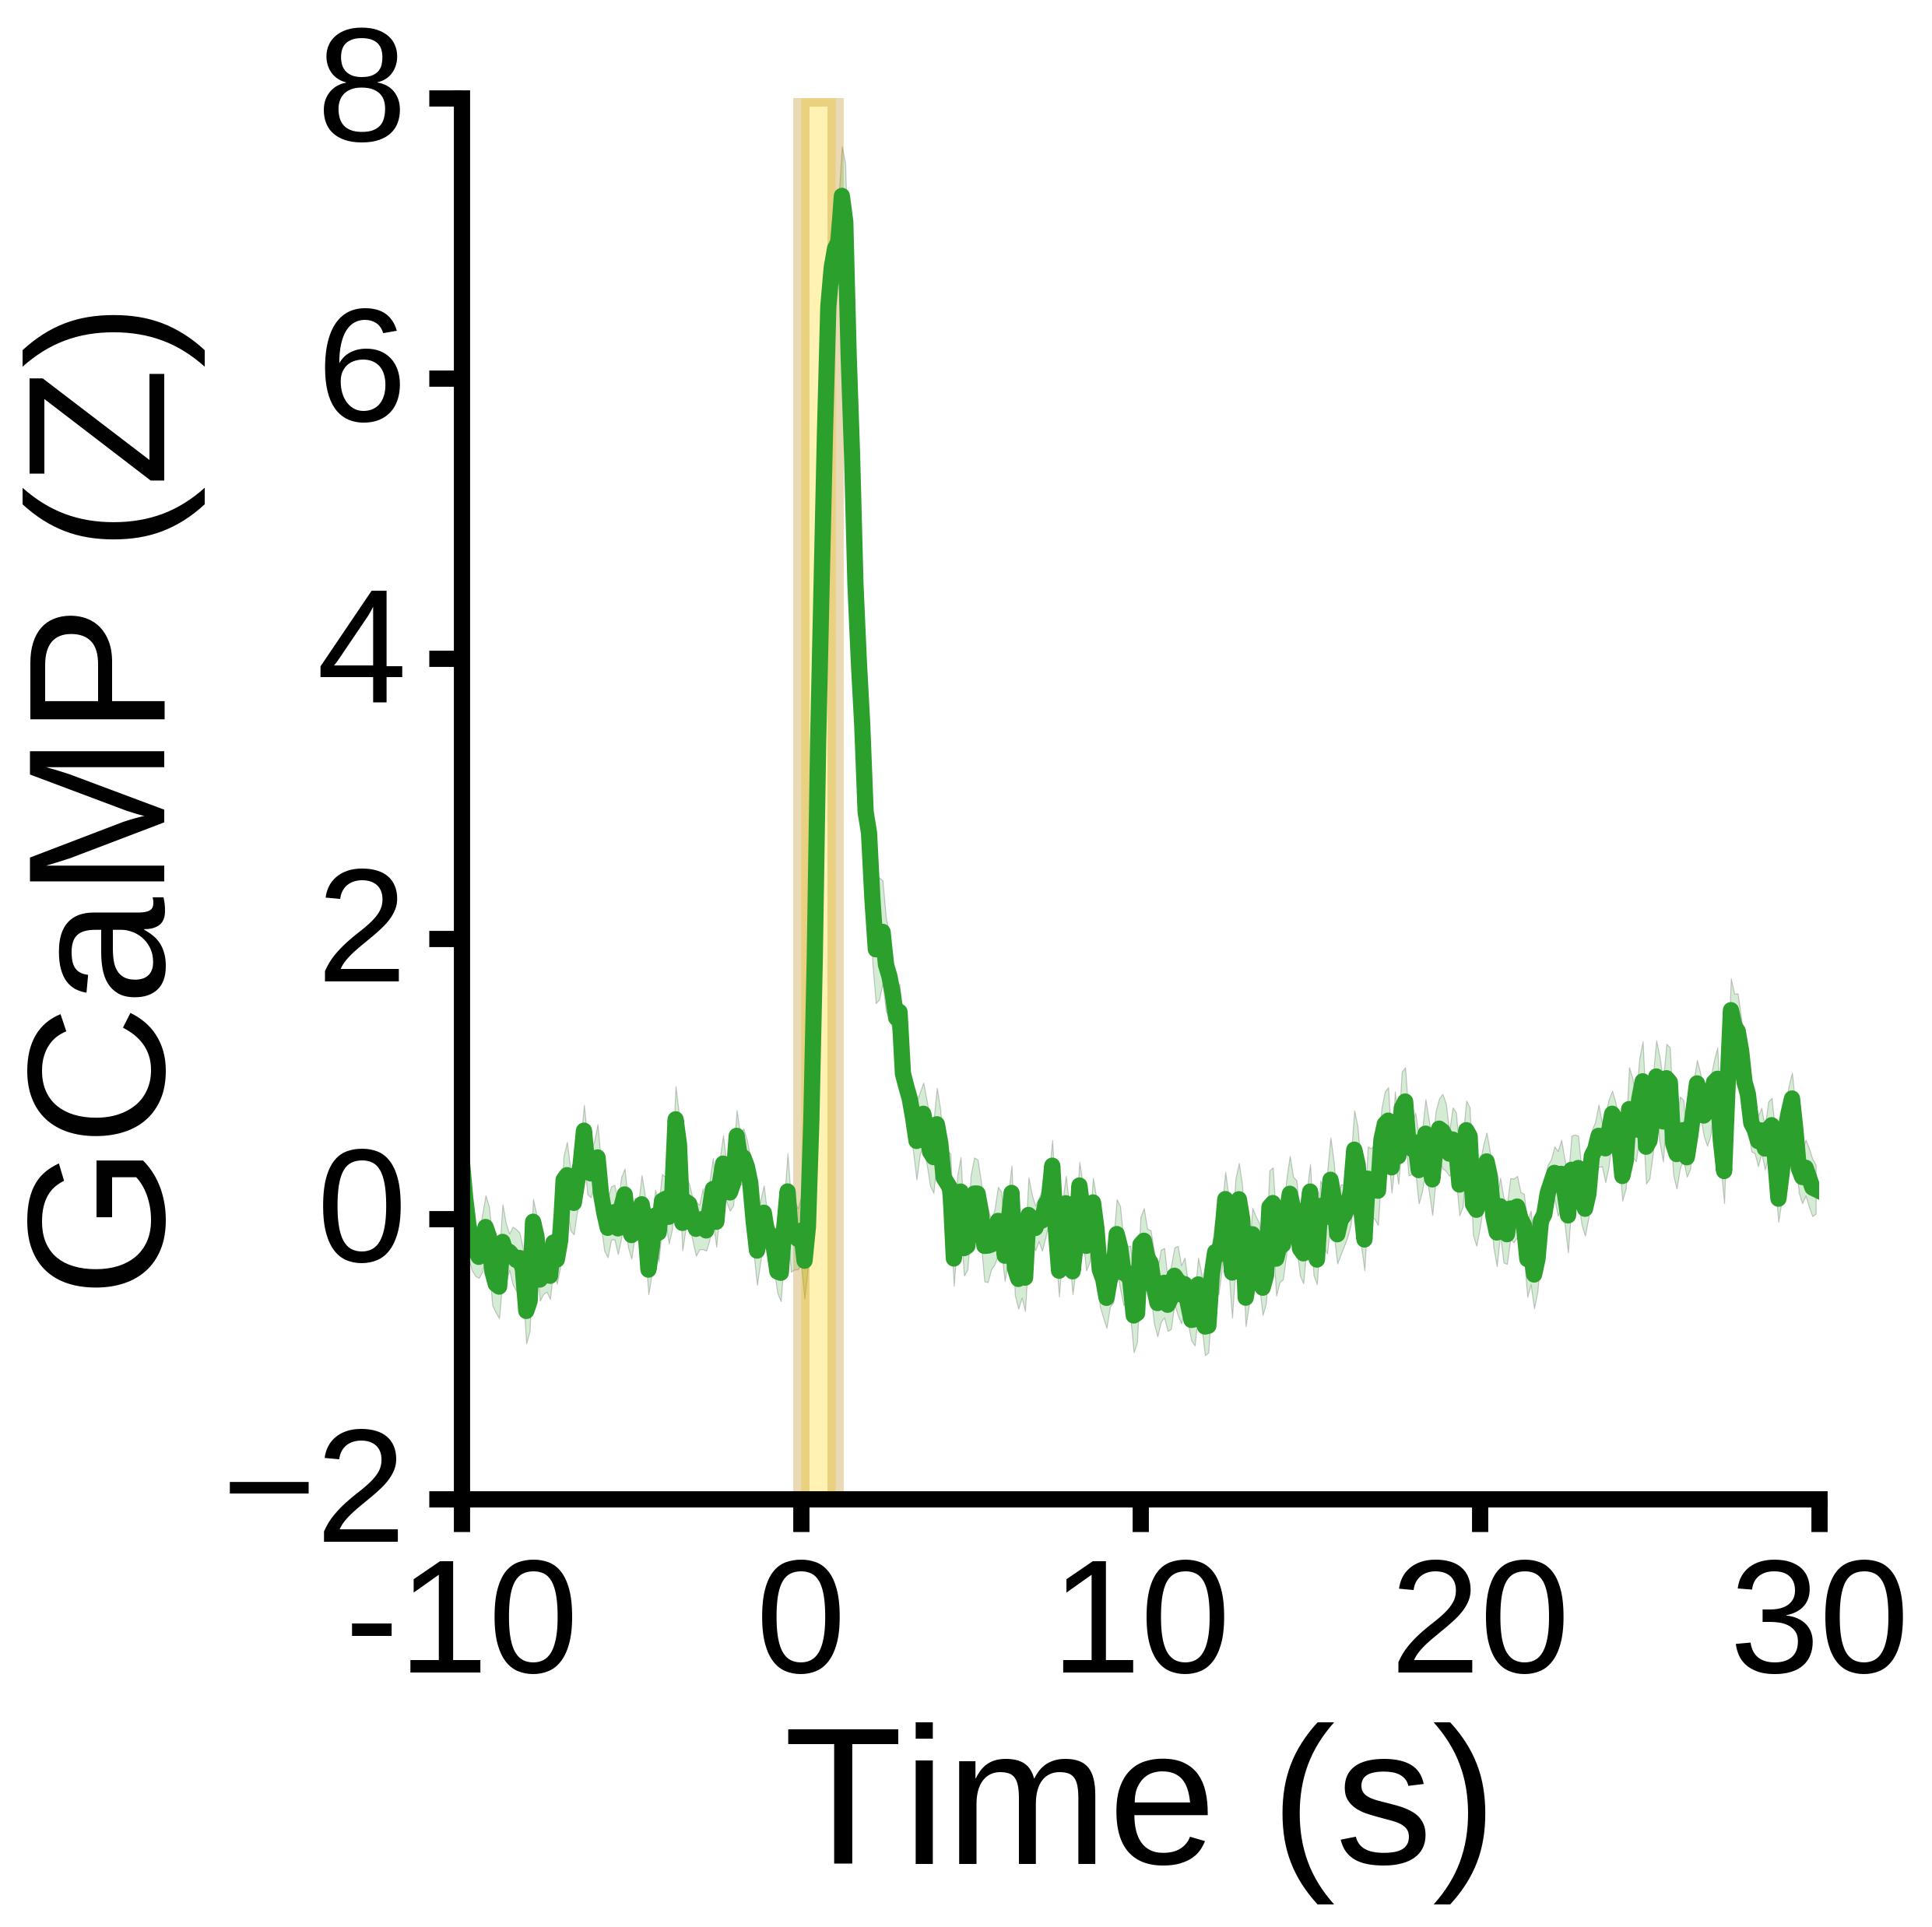

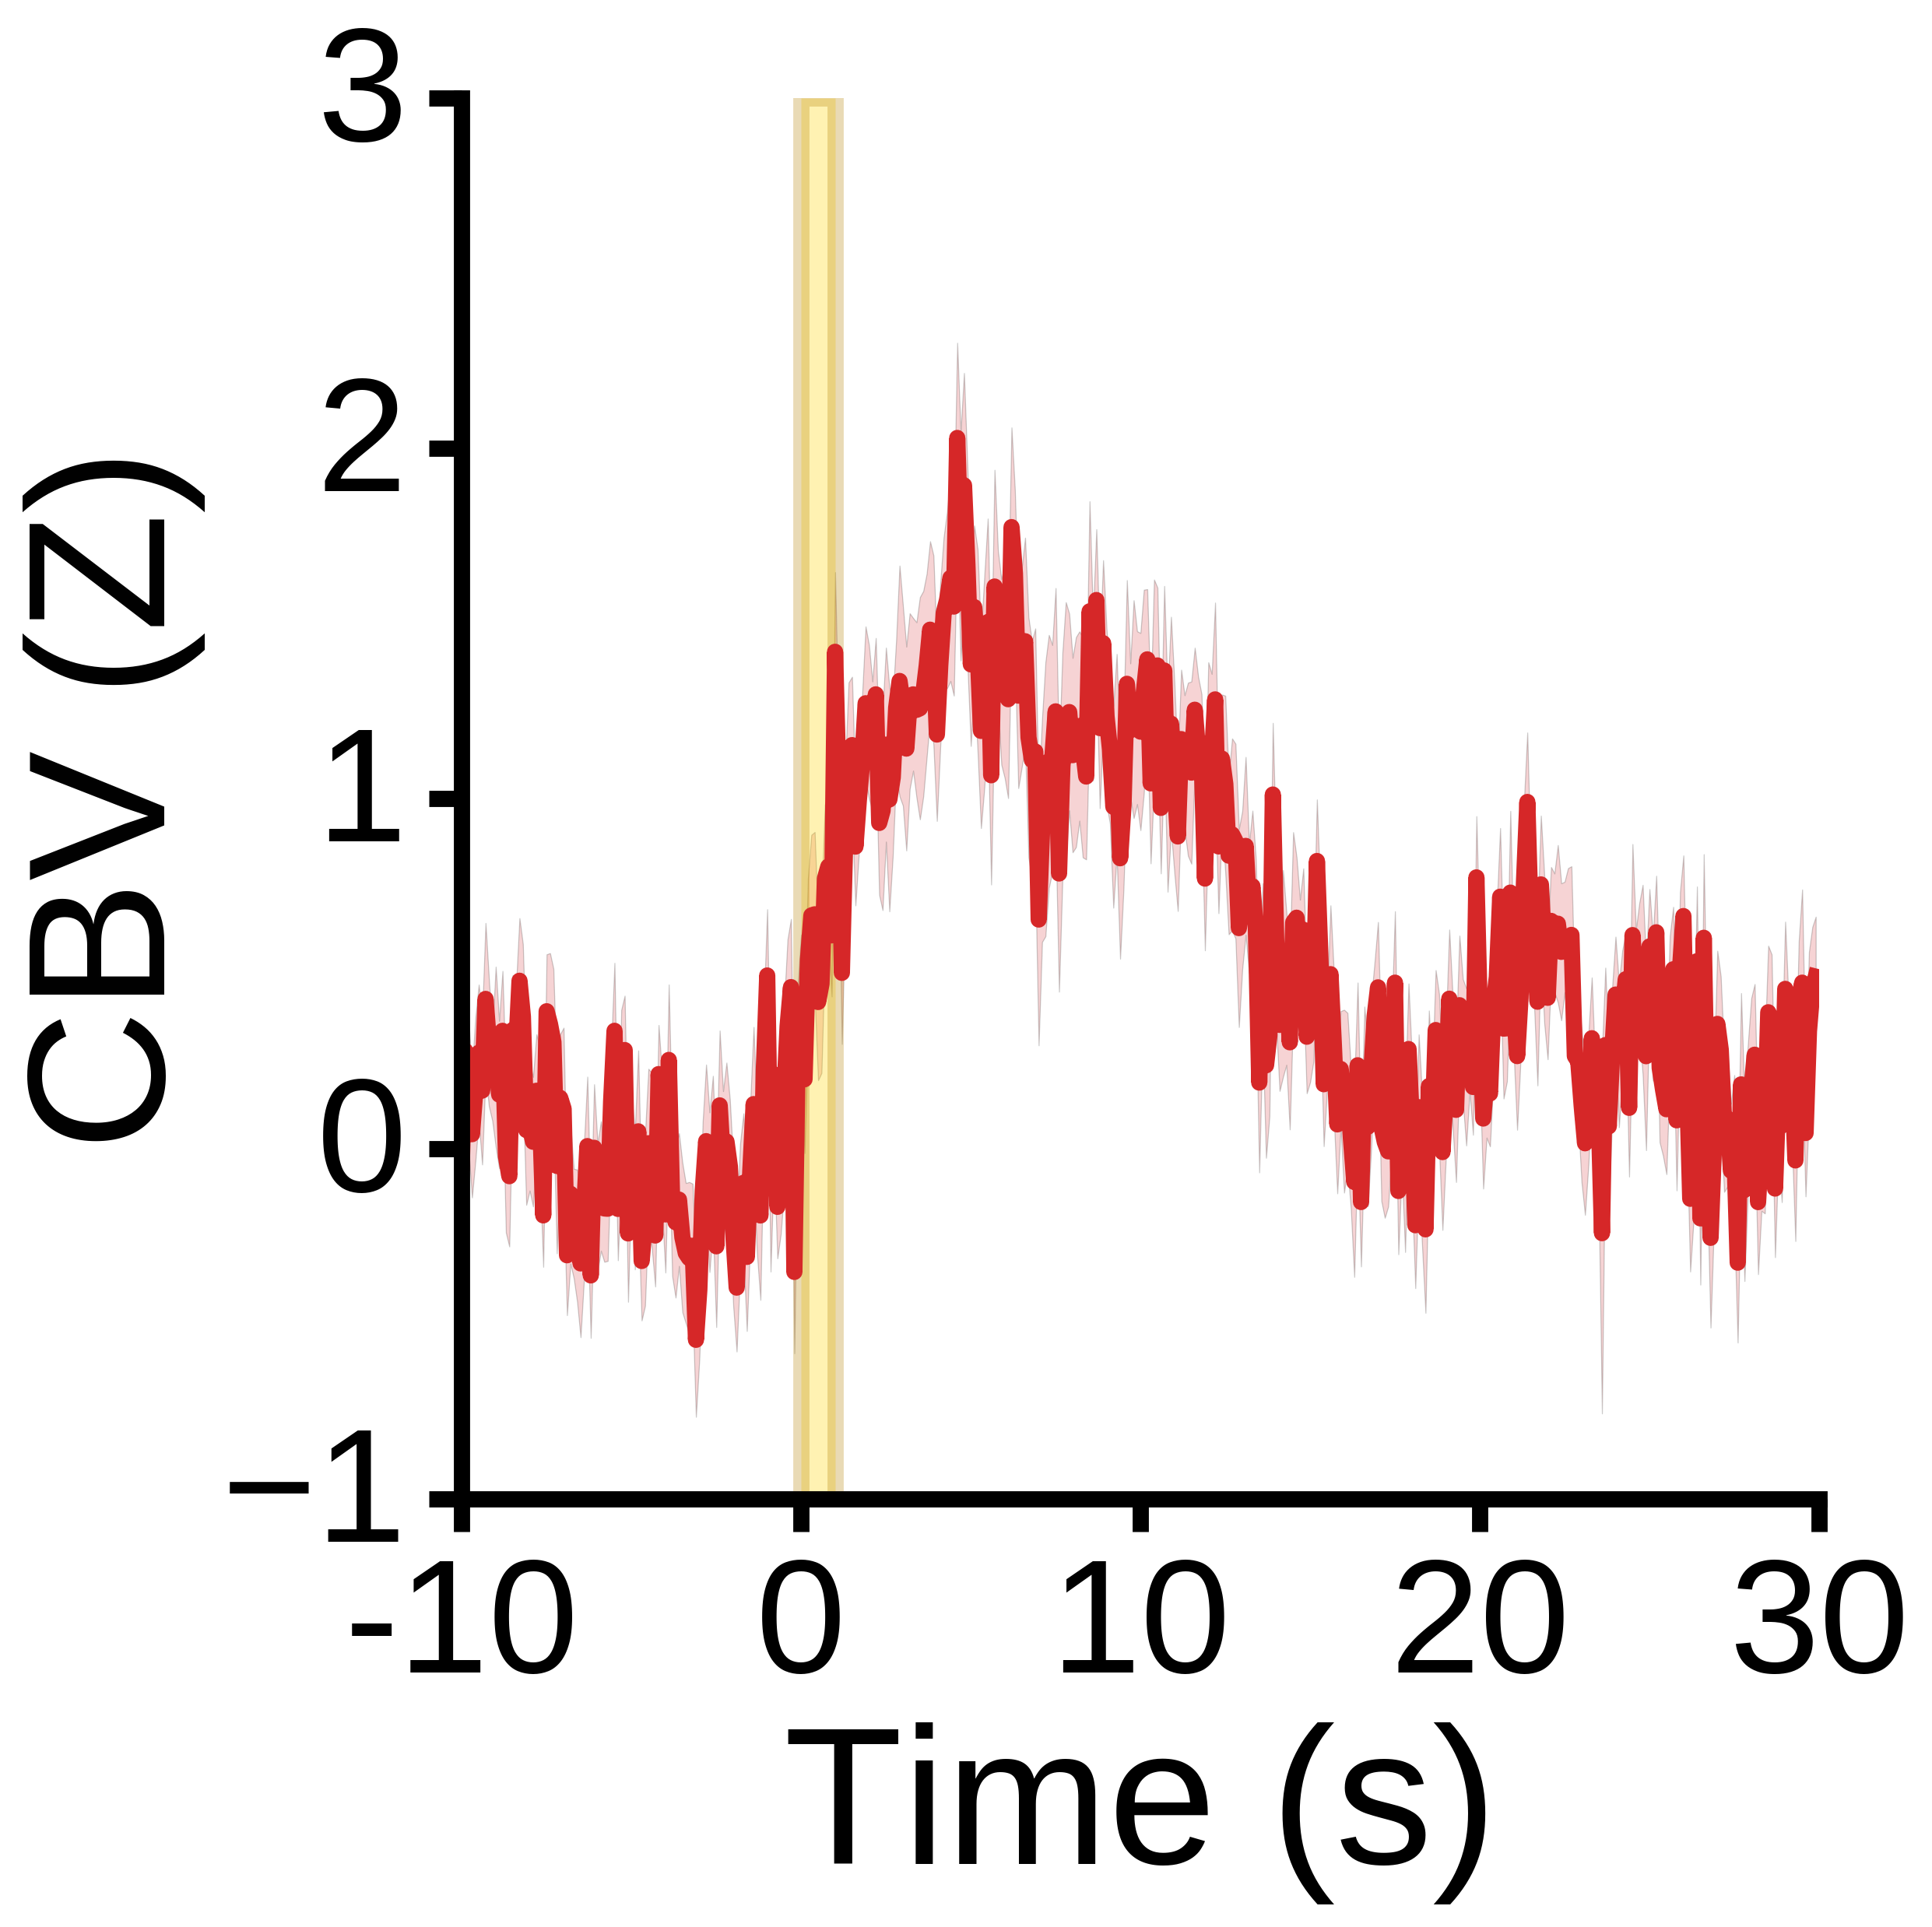

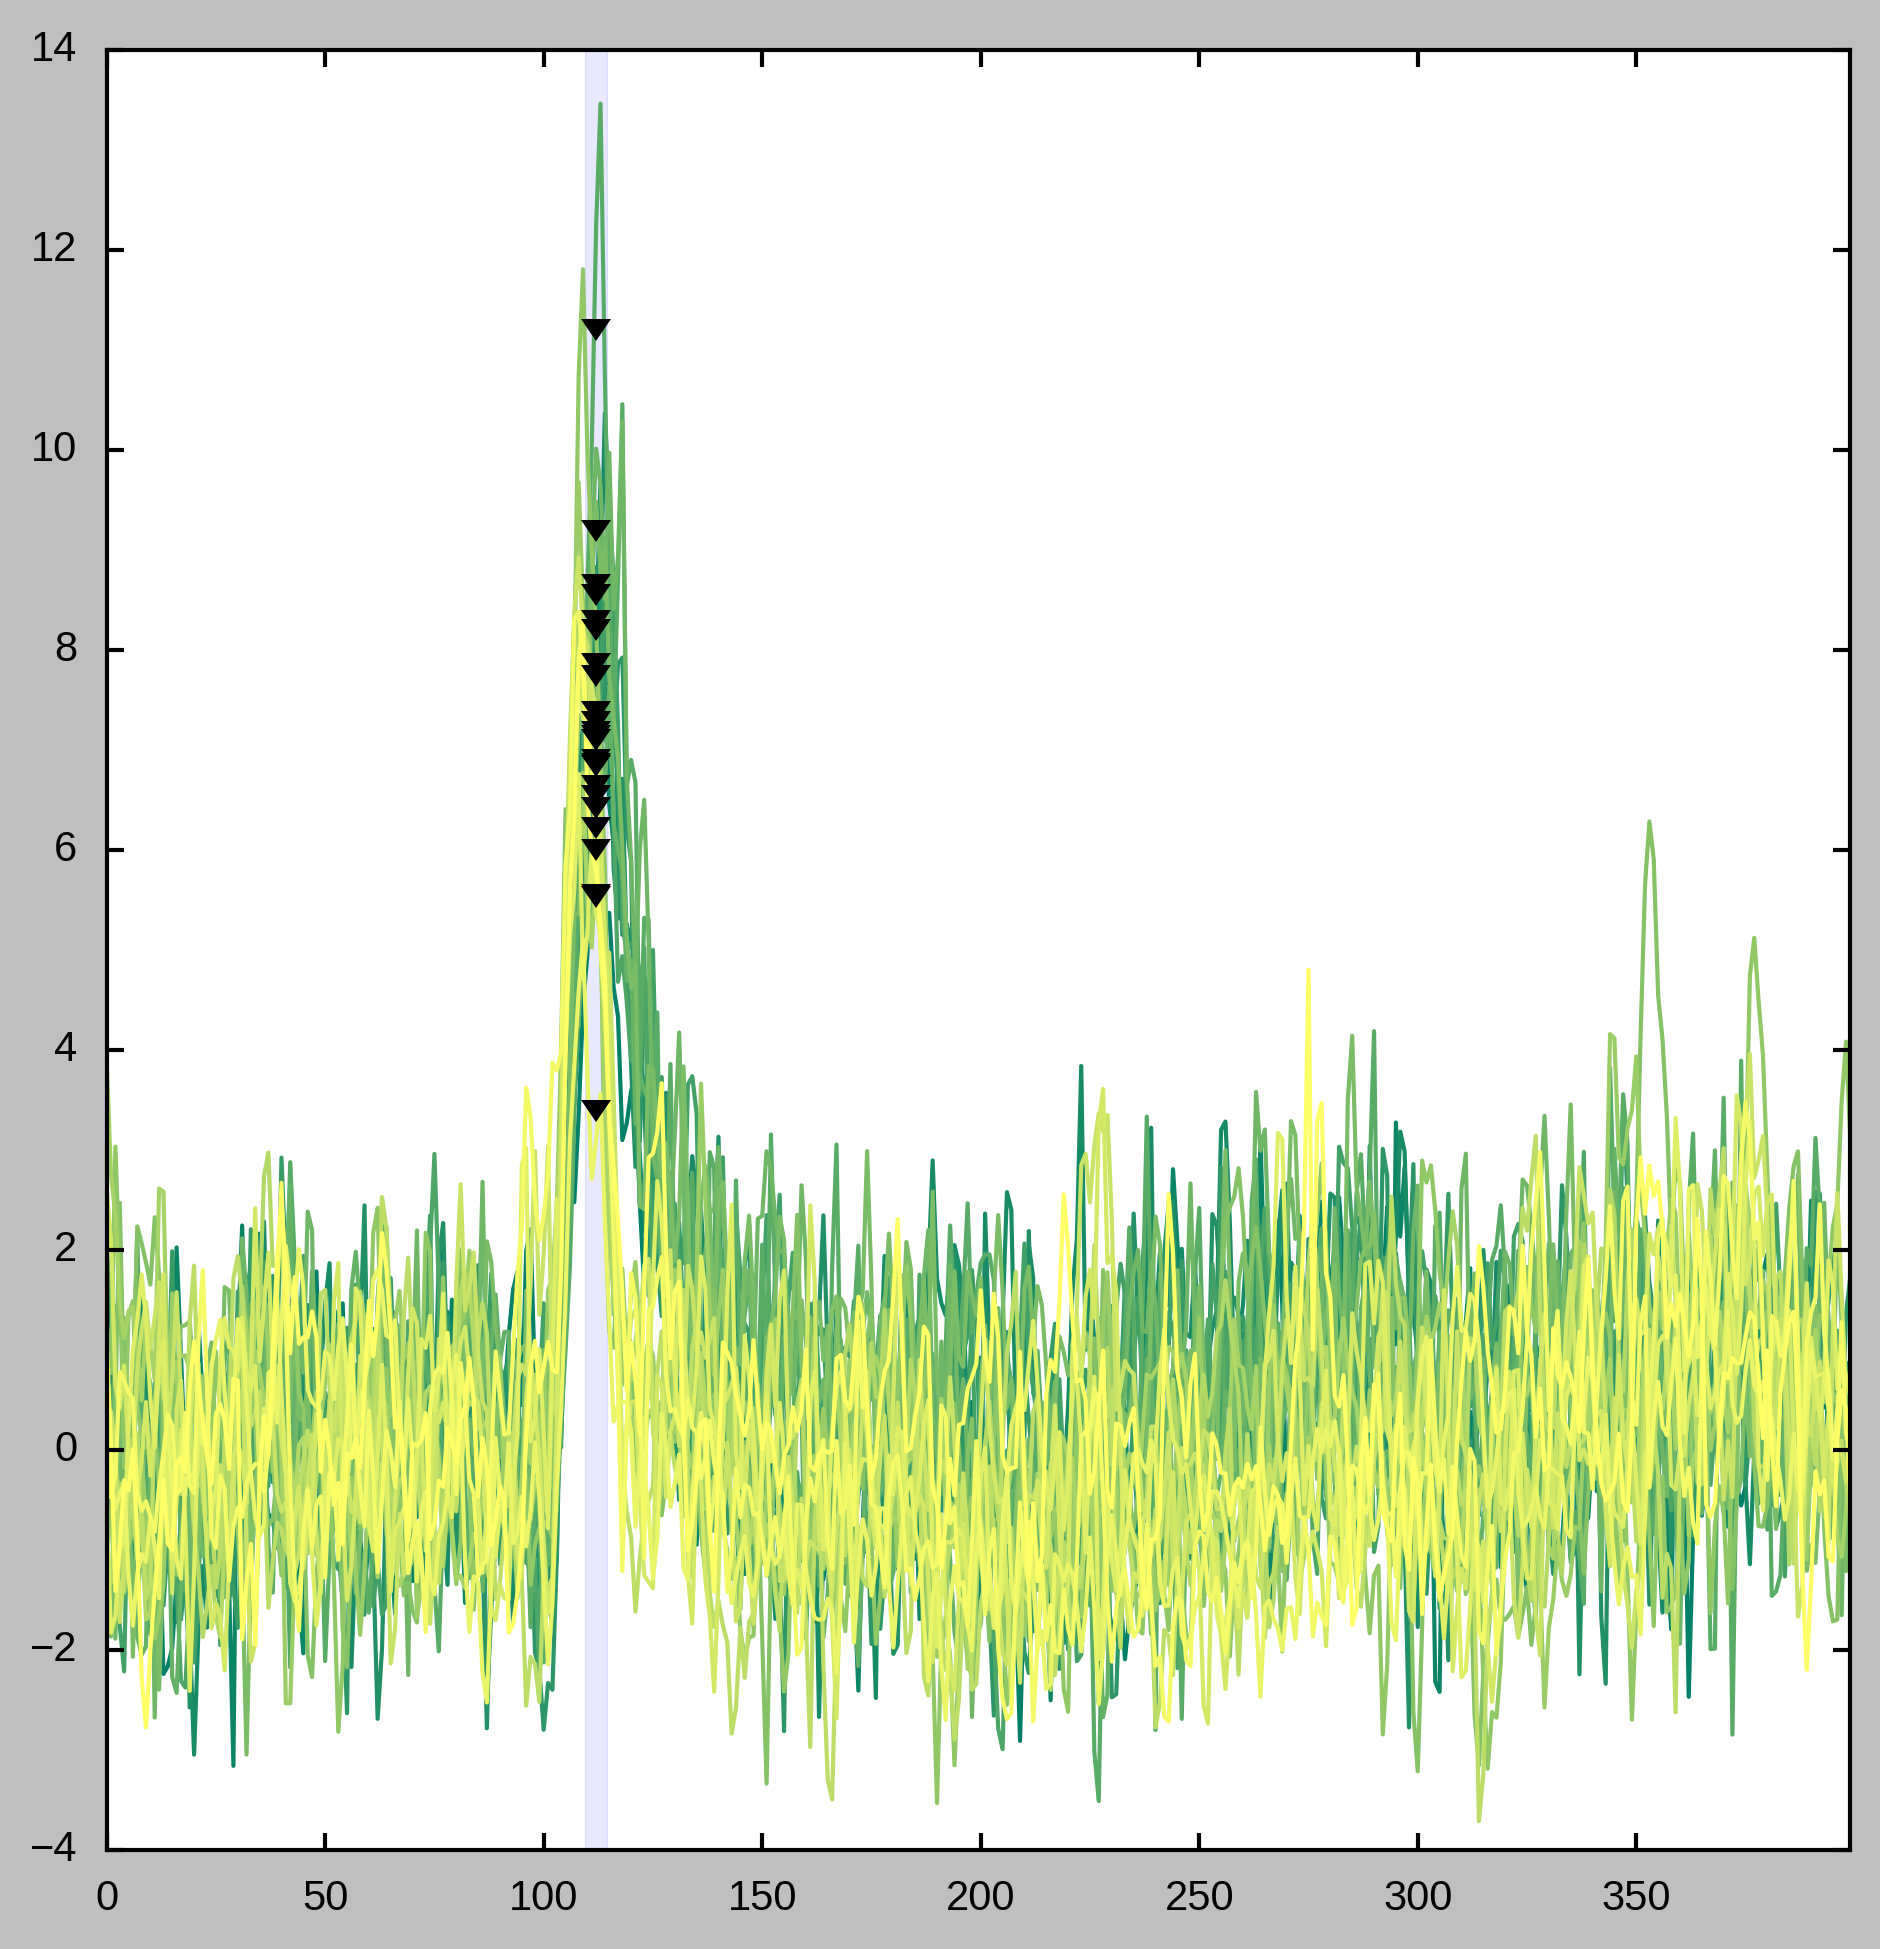

146


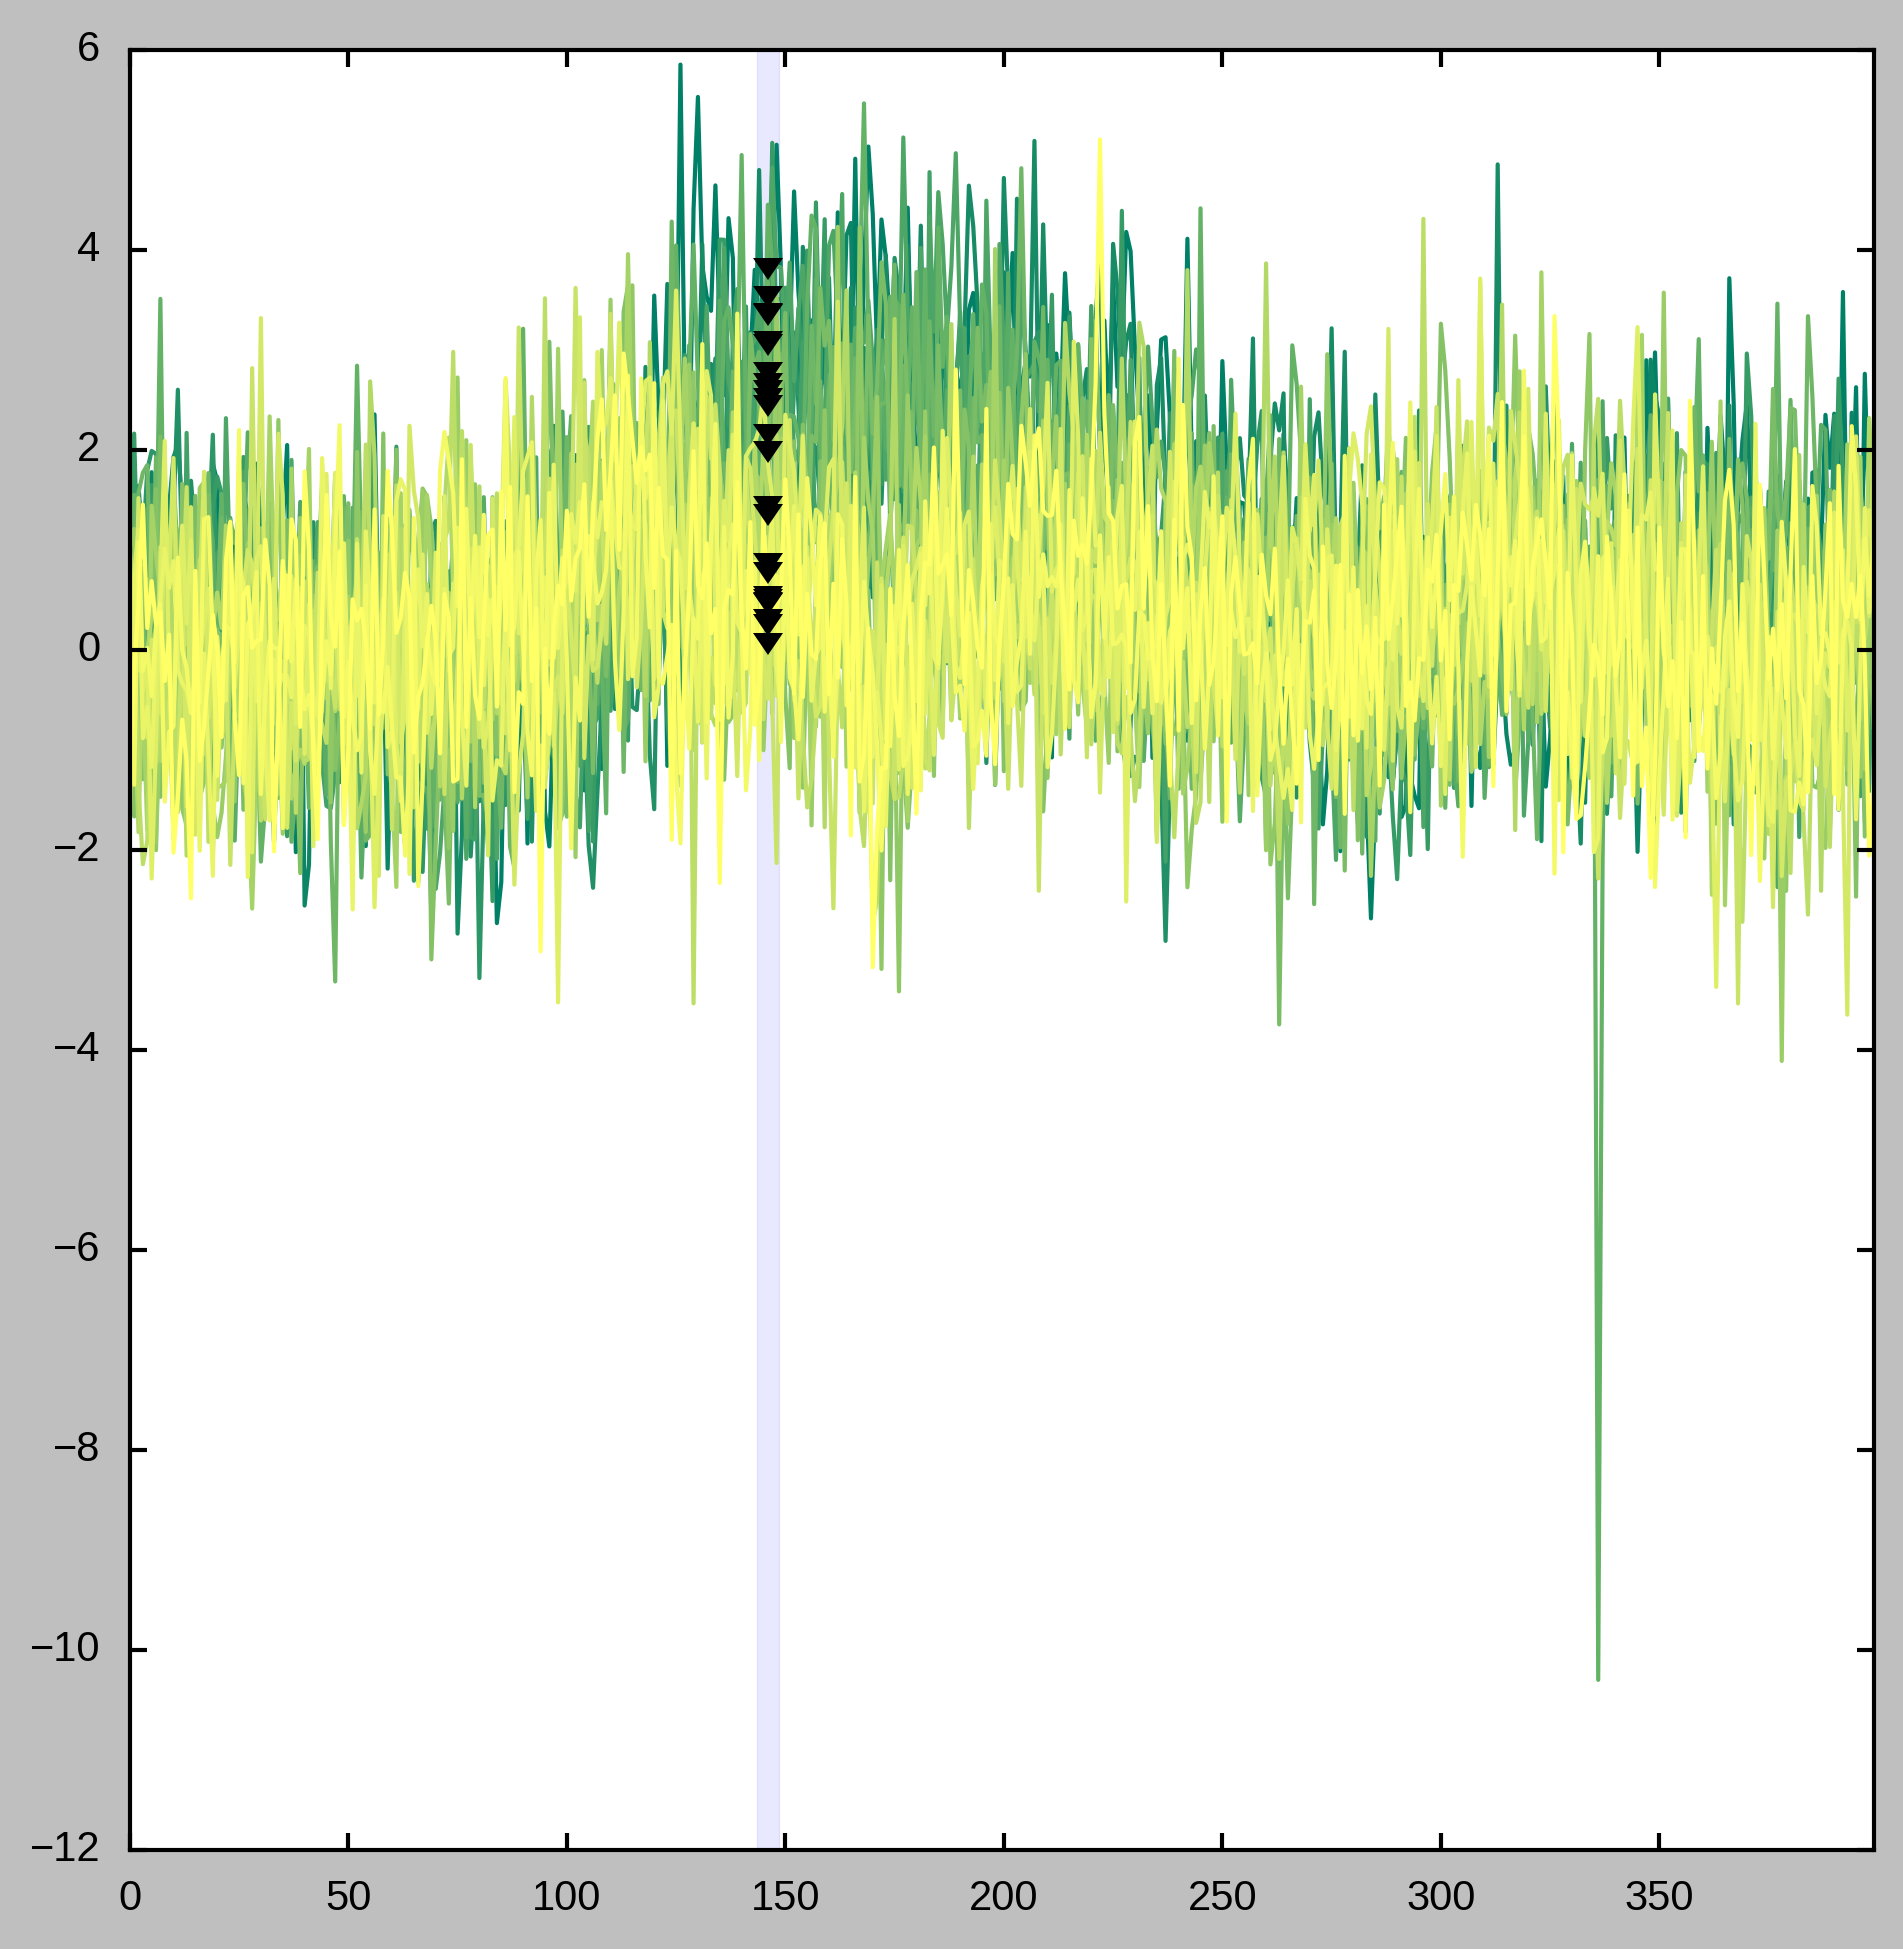

((<matplotlib.figure.Figure at 0x7fd9d00f0f10>,
  <matplotlib.axes._subplots.AxesSubplot at 0x7fd9c8a39450>),
 (<matplotlib.figure.Figure at 0x7fd9c89e0590>,
  <matplotlib.axes._subplots.AxesSubplot at 0x7fd9c8a1e850>),
 <matplotlib.axes._subplots.AxesSubplot at 0x7fd9c876ed90>)

In [22]:
plot_data(prj, 'groupname') #enter folder name of the group you want